EDA --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-eda-s4e3)  
RF/XGB/LGBM & model explaination --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-rf-xgb-lgbm-model-explaination-s4e3)  
Origin vs. Train datasets, effect of adding original dataset on model score --> [Link](https://www.kaggle.com/code/ustcer1984/steel-plate-effect-of-adding-original-data-s4e3)

### Objective

- Study if improving data balance by resampling can improve model score or not.

In [1]:
# setup environment
input_path = './data/'
output_path = './output04/'

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None) # show all columns

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, PercentFormatter
import seaborn as sns
sns.set_theme() # I like seaborn default theme

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn import metrics
from sklearn.inspection import permutation_importance
import shap

import pickle

import warnings
warnings.filterwarnings('ignore') # suppress warning msg

In [2]:
# load raw data
df_train_raw = pd.read_csv(input_path + 'train.csv') # train dataset
df_test_raw = pd.read_csv(input_path + 'test.csv') # test dataset
df_origin_raw = pd.read_csv(input_path + 'Steel Plates Faults.csv') # original dataset

predict_features = df_train_raw.columns.to_list()[-7:]

# X transformer function
def X_transformer(X_raw):
    X = X_raw.copy()
    X['X_Center'] = (X['X_Maximum'] + X['X_Minimum'])/2
    X['X_Range'] = X['X_Maximum'] - X['X_Minimum']
    X['Y_Center'] = (X['Y_Maximum'] + X['Y_Minimum'])/2
    X['Y_Range'] = X['Y_Maximum'] - X['Y_Minimum']
    X['Aspect_Ratio'] = X['Y_Perimeter'] / X['X_Perimeter']
    X['Mean_Luminosity'] = X['Sum_of_Luminosity'] / X['Pixels_Areas']
    X['Delta_Luminosity'] = X['Maximum_of_Luminosity'] - X['Minimum_of_Luminosity']
    X['Log_Pixel_Resolution'] = ((10**X['LogOfAreas']) / X['Pixels_Areas']).apply(np.log10)
    if 'id' in X.columns:
        X.drop(columns=['id'], inplace=True)
    return X

df_origin = X_transformer(df_origin_raw)
df_train_full = X_transformer(df_train_raw)
df_test = X_transformer(df_test_raw)

# split train, val datasets
stratify = np.zeros(df_train_full.shape[0])
for defect in predict_features:
    stratify = 10*stratify + df_train_full[defect]
## combine dual labelled groups to avoid split error (only 1 row in a group)
stratify = stratify.apply(lambda x: 10001 if x in [10010, 1010000] else x)
## split
df_train, df_val = train_test_split(df_train_full, test_size=0.25,
                                    stratify=stratify, random_state=42)
X_val = df_val.drop(columns=predict_features)
Y_val = df_val[predict_features]

### 1. Improve data balance for each defect type

Since the defects are seperately labelled and we need to build models specifically to fit each of them, the target data may be imbalanced.

Pastry          0.076279
Z_Scratch       0.059837
K_Scatch        0.178573
Stains          0.029554
Dirtiness       0.025235
Bumps           0.247828
Other_Faults    0.341225
dtype: float64


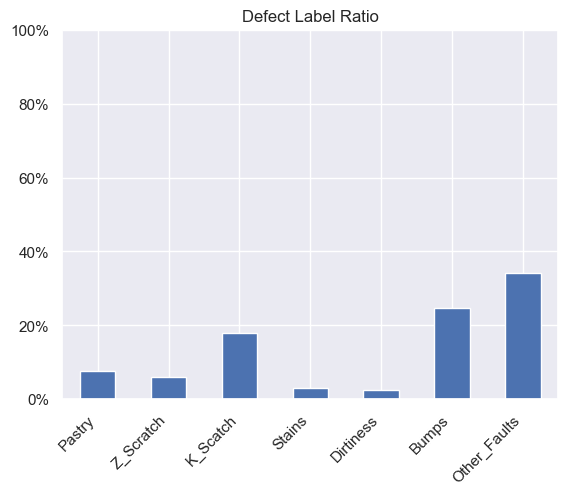

In [3]:
print(df_train_full[predict_features].mean())
ax = df_train_full[predict_features].mean().plot.bar()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.ylim(0,1)
plt.xticks(rotation=45, ha='right')
plt.title('Defect Label Ratio')
plt.show()

Some defect types (e.g. `stains`, `Dirtiness`) show very low population ratio. Maybe we can improve model score by upsampling these data?

**Experiment setup**  
- In train dataset, duplicate data labelled as specific defect type.
    - In below codes, `fold` is the number of times the defect data is duplicated.
- `LGBMClassifier` with default parameters is used for this study.

In [4]:
summary = {'fold': [i for i in range(1, 31)]}
for defect in predict_features:
    df_train_n = df_train[df_train[defect]==0] # defect: no
    df_train_y = df_train[df_train[defect]==1] # defect: yes
    summary[defect] = []
    for fold in summary['fold']:
        df_train_f = pd.concat([df_train_n] + [df_train_y] * fold, axis=0).\
                        sample(frac=1, random_state=314) # shuffle data
        X_train = df_train_f.drop(columns=predict_features)
        y_train = df_train_f[defect]
        y_val = Y_val[defect]
        model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=314)
        model.fit(X_train, y_train)
        summary[defect].append(
            metrics.roc_auc_score(y_val,
                                model.predict_proba(X_val)[:, 1])
        )

In [5]:
df_summary = pd.DataFrame(summary).set_index('fold')
for defect in df_summary.columns:
    df_summary[defect] = df_summary[defect] - df_summary.loc[1, defect]
df_summary['Average'] = df_summary.mean(axis=1)

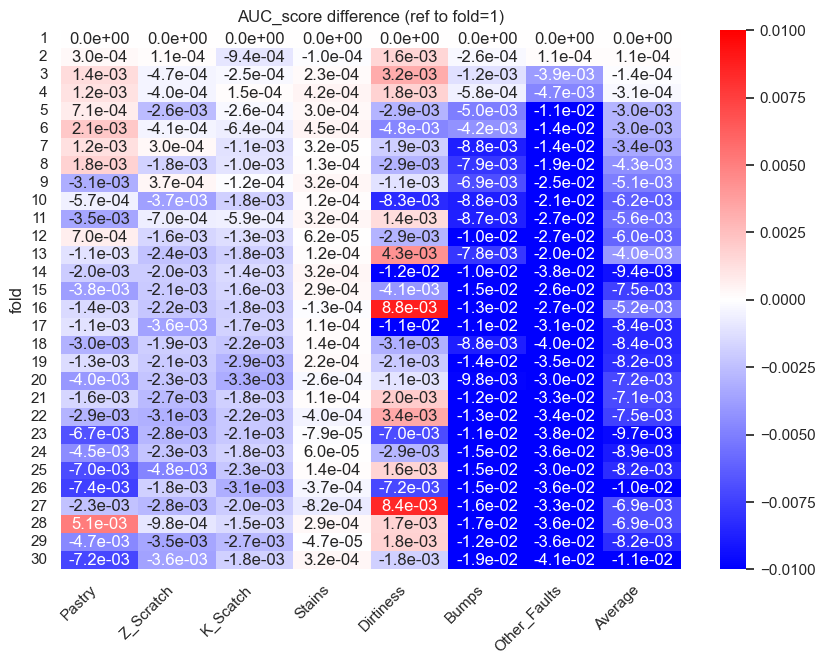

In [6]:
plt.figure(figsize=(10, 7))
sns.heatmap(df_summary, cmap='bwr', annot=True, fmt='.1e',
            vmax=0.01, vmin=-0.01)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.title('AUC_score difference (ref to fold=1)')
plt.show()

Score improvement can be observed for `Pastry` (6 folds), `Stains` (6 folds) and `Dirtiness` (3 folds).  
- The positive sign is continous positive score_diff values at low fold values.
- `Pastry` shows best score_diff with 28 folds, but both 27 and 29 folds show significantly worse performance. So the improvement with 28 folds is likely from fluctuation only.
- Don't forget we don't need to use the same fold value for all defects. Instead, we can choose the most suitable fold value for each respective defect type.

In [7]:
score_diff = (df_summary.loc[6,'Pastry'] + 
              df_summary.loc[6, 'Stains'] + 
              df_summary.loc[3, 'Dirtiness']) / 7
print('Average_score_diff = {:.2%}'.format(score_diff))

Average_score_diff = 0.08%


In [8]:
# prepare submit file
df_submit = df_test_raw[['id']]
for defect in predict_features:
    # best fold for specific defect
    if defect in ['Pastry', 'Stains']: fold = 6
    elif defect == 'Dirtiness': fold = 3
    else: fold = 1
    # prepare train data
    df_train_n = df_train_full[df_train_full[defect]==0] # defect: no
    df_train_y = df_train_full[df_train_full[defect]==1] # defect: yes
    df_train_f = pd.concat([df_train_n] + [df_train_y] * fold, axis=0).\
                    sample(frac=1, random_state=314) # shuffle data
    X_train = df_train_f.drop(columns=predict_features)
    y_train = df_train_f[defect]
    # fit model
    model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=314)
    model.fit(X_train, y_train)
    df_submit[defect] = model.predict_proba(df_test)[:, 1]
# output file
df_submit.to_csv(output_path+'submit_1.csv', index=False)

### 2. Balance original dataset inclusion in train dataset

Our [last work](https://www.kaggle.com/code/ustcer1984/steel-plate-effect-of-adding-original-data-s4e3) shows slight model score improvement by including original dataset.  
Is it possible to futher improve along this track?

In [9]:
print('Origin data size =  {:,d}'.format(df_origin_raw.shape[0]))
print(' Train data size = {:,d}'.format(df_train_raw.shape[0]))

Origin data size =  1,941
 Train data size = 19,219


The original dataset sample size is much smaller than train dataset.  
Maybe there is benefit to upsampling original data.

In [10]:
summary2 = {'fold': [i for i in range(0, 30)]}
for defect in predict_features:
    summary2[defect] = []
    for fold in summary2['fold']:
        df_train_f = pd.concat([df_train] + [df_origin] * fold, axis=0).\
                        sample(frac=1, random_state=314) # shuffle data
        X_train = df_train_f.drop(columns=predict_features)
        y_train = df_train_f[defect]
        y_val = Y_val[defect]
        model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=314)
        model.fit(X_train, y_train)
        summary2[defect].append(
            metrics.roc_auc_score(y_val,
                                model.predict_proba(X_val)[:, 1])
        )
# summary DataFrame
df_summary2 = pd.DataFrame(summary2).set_index('fold')
for defect in df_summary2.columns:
    df_summary2[defect] = df_summary2[defect] - df_summary2.loc[0, defect]
df_summary2['Average'] = df_summary2.mean(axis=1)


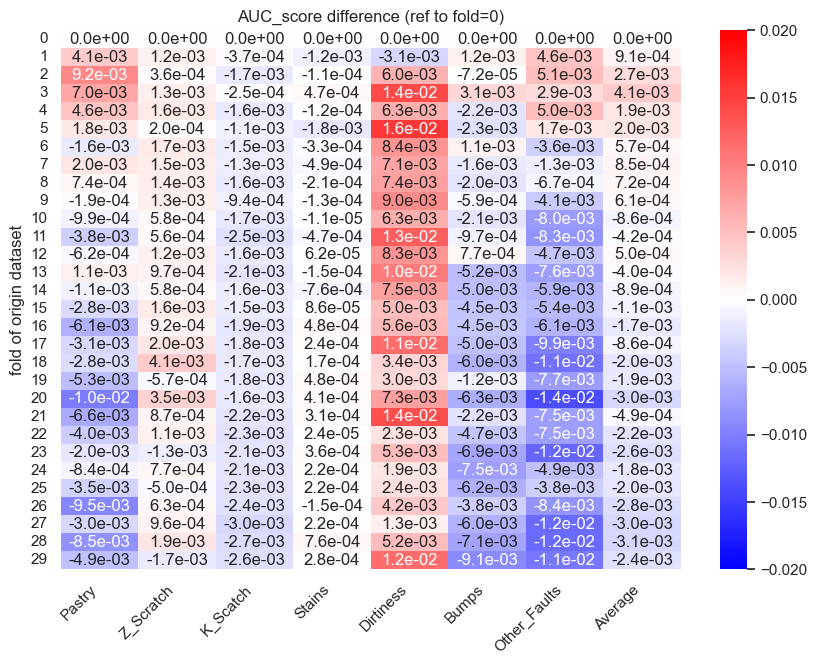

In [11]:
# plot
plt.figure(figsize=(10, 7))
sns.heatmap(df_summary2, cmap='bwr', annot=True, fmt='.1e',
            vmax=0.02, vmin=-0.02)
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.title('AUC_score difference (ref to fold=0)')
plt.ylabel('fold of origin dataset')
plt.show()

In [12]:
origin_folds = [2, 6, 0, 0, 5, 1, 2]
df_temp = pd.DataFrame({'fold': ['fold of origin data']})
df_temp.set_index('fold', inplace=True)
for i in range(len(predict_features)):
    df_temp[predict_features[i]]=[origin_folds[i]]
df_temp

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
fold,,,,,,,
fold of origin data,2,6,0,0,5,1,2


In [13]:
score_diff = 0
for i in range(len(predict_features)):
    score_diff += df_summary2.loc[origin_folds[i], predict_features[i]]
print('Average_score_diff = {:.2%}'.format(score_diff/7))

Average_score_diff = 0.47%


Quite ***significant improvement***!  
- **NOTE**: NOT all defect type detection benefit from adding original dataset.

In [14]:
# prepare submit file
df_submit2 = df_test_raw[['id']]
for defect in predict_features:
    # best fold for specific defect
    fold = origin_folds[predict_features.index(defect)]
    fold = round(fold * 4/3) # maintain same ratio of origin:train
    # prepare train data
    df_train_f = pd.concat([df_train_full] + [df_origin] * fold, axis=0).\
                    sample(frac=1, random_state=314) # shuffle data
    X_train = df_train_f.drop(columns=predict_features)
    y_train = df_train_f[defect]
    # fit model
    model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=314)
    model.fit(X_train, y_train)
    df_submit2[defect] = model.predict_proba(df_test)[:, 1]
# output file
df_submit2.to_csv(output_path+'submit_2.csv', index=False)